French Fake News Detection model with camemBERT model

This notebook contains : 
- Preparation input data
- Training camemBERT Sequence Classification (using "simpletransformers")
- Evaluation

Works on Google Colab 
- Choose GPU  Execution type


## Google Drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Installation

In [12]:
!pip install simpletransformers

## Import

In [0]:
%matplotlib inline

# for figure
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)

# for training
from simpletransformers.classification import ClassificationModel

# to save 
import pickle
from sklearn.externals import joblib

# useful
import pandas as pd
import numpy as np
import shutil
import os
from sklearn.metrics import accuracy_score

## Definitions

In [0]:
# your data folder
PATH_FOLDER_SAVE = '/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data'

PATH_DF_FAKE_NEWS = PATH_FOLDER_SAVE + '/df_fake_news.pkl'
PATH_DF_TRUE_NEWS = PATH_FOLDER_SAVE + '/df_true_news.pkl'

# % of data used for training
train_percent = 0.7

# path folder saved model
PATH_FOLDER_MODEL_SAVED = '/content/drive/My Drive/outputs_proj7'

LIST_FILES_TO_SAVE = ["added_tokens.json", "config.json", "eval_results.txt",
                      "pytorch_model.bin" ,"sentencepiece.bpe.model", 
                      "special_tokens_map.json", "tokenizer_config.json", 
                      "training_args.bin"]
 
# maximum number of epochs because of space                     
MAX_NB_EPOCHS = 33 

# save df news
PATH_DF_NEWS_SAVE = PATH_FOLDER_SAVE + '/df_news.pkl' 

## Useful functions

In [0]:
def display_missing(df):
    '''
    Display dataFrame missing values : barplots & numbers
    ouput : dataFrame containing missing numbers
    '''
    nb_lignes = df.shape[0]
    nb_missing = df.isnull().sum()
    nb_missing = nb_missing.sort_values()
    df_missing = nb_missing.to_frame()
    df_missing.rename(index=str, columns={0: "nb_missing"}, inplace=True)
    df_missing["ratio"] = 100*df_missing["nb_missing"] / nb_lignes
    fig = plt.figure(figsize=(7, 7))
    liste_name_bars = df_missing.index.values
    liste_name_bars_num = []
    for name in liste_name_bars:
        liste_name_bars_num.append("{} [{}]".format(
            name, df_missing.loc[name, "nb_missing"]))
    ax = sns.barplot(y=liste_name_bars_num, x='ratio', data=df_missing)
    plt.title('Missing lines Ratio over {} lines'.format(nb_lignes))
    ax.set(xlabel='repartition [%]')
    ax.set_xlim([0, 100])
    return df_missing

def save_model_folder(path_folder_source, path_folder_dest):
  '''
  Save model folder to be reused
  '''
  
  if os.path.isdir(path_folder_dest) == False:
    os.mkdir(path_folder_dest)
  for file_curr in LIST_FILES_TO_SAVE:
    shutil.copyfile(path_folder_source + '/' + file_curr, 
                    path_folder_dest + '/' + file_curr)

def check_file_permissions(file_name):
  '''
  Python program to get file permission mask 
  of a given file
  '''

  # Get the file permission mask 
  # of the specified file 
  mask = oct(os.stat(file_name).st_mode)[-3:] 
  
  # Print the mask 
  print("File permission mask:", mask) 

In [16]:
check_file_permissions("/content/drive/My Drive/OpenClassRooms/IML_Projet_7/code/FakeNewsDetectionFr/README.md")

File permission mask: 600


## Prepare Data 

### Concatenate news sources 

In [0]:
df_true = joblib.load(PATH_DF_TRUE_NEWS)
df_fake = joblib.load(PATH_DF_FAKE_NEWS)

In [0]:
df_true = df_true.filter(items=["url", "source", "author", "title", "theme", 
                      "description", "date_published", "body"])
df_fake = df_fake.filter(items=["url", "source", "author", "title", "theme", 
                      "description", "date_published", "body"])

In [0]:
df_true["fake"] = 0
df_fake["fake"] = 1

In [0]:
df_news = pd.concat([df_true, df_fake], ignore_index=True)

In [84]:
df_news.shape

(2534, 9)

,nb_missing,ratio
url,0,0.000000
source,0,0.000000
author,0,0.000000
title,0,0.000000
theme,0,0.000000
date_published,0,0.000000
body,0,0.000000
fake,0,0.000000
description,453,17.876875


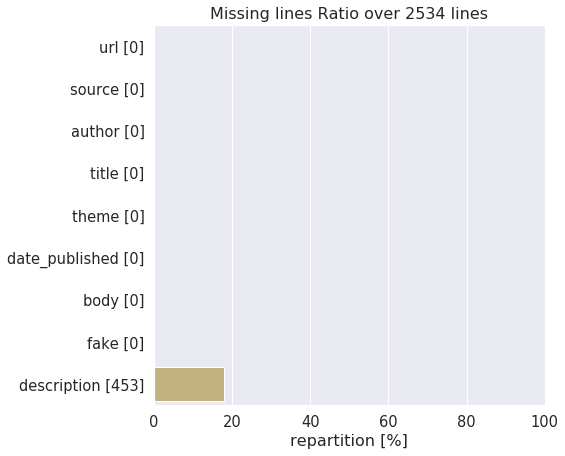

In [22]:
display_missing(df_news)

### Explore sources

In [23]:
df_news["source"].value_counts()

LeGorafi           621
20Minutes          585
Liberation         333
Futura Sciences    317
Buzzbeed           240
Nordpresse         211
Telerama           101
Le Monde            66
Le Figaro           60
Name: source, dtype: int64

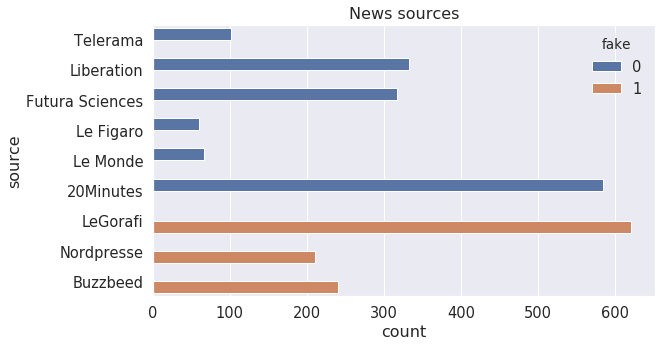

In [24]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News sources")
ax = sns.countplot(y="source", hue="fake", data=df_news)

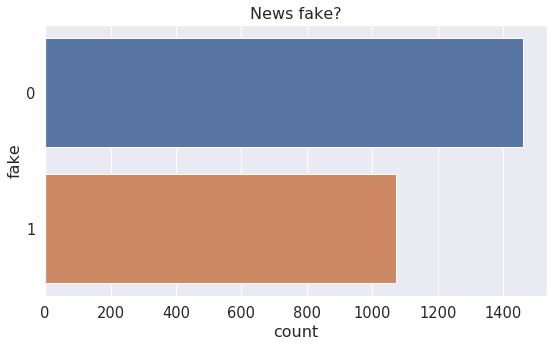

In [25]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News fake?")
ax = sns.countplot(y="fake", data=df_news)

### Balance news sources/themes

In [85]:
df_news.shape

(2534, 9)

In [86]:
# delete Telerama source not appropriate 
df_news = df_news[df_news["source"] != "Telerama"]
df_news.shape

(2433, 9)

In [46]:

'''# reduce by half Futura Science news number
df_fs = df_news[df_news["source"] == "Futura Sciences"]
df_fs = df_fs.head(np.int(df_fs.shape[0]/2))

# delete source not appropriate 
df_news = df_news[df_news["source"] != "Futura Sciences"]
# add half
df_news = pd.concat([df_news, df_fs], ignore_index=True, sort=False)
df_news.shape'''

(2274, 9)

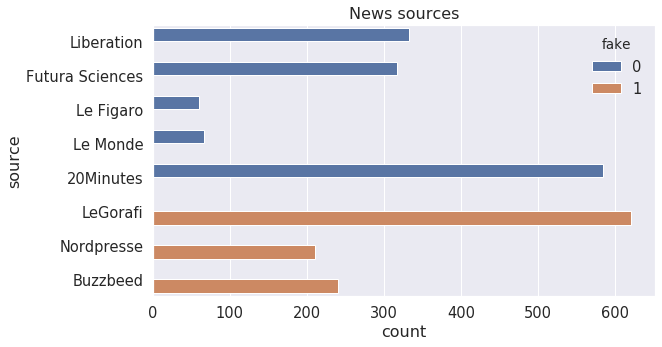

In [87]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News sources")
ax = sns.countplot(y="source", hue="fake", data=df_news)

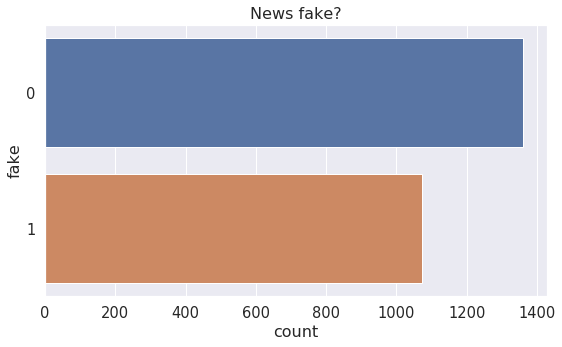

In [88]:
# Categorical bar plot with train/test
fig = plt.figure(figsize=(9, 5))
plt.title("News fake?")
ax = sns.countplot(y="fake", data=df_news)

### Concatenate Title & Body

In [0]:
# prepare format data
df_news["text"] = df_news["title"] + " " + df_news["body"]

In [90]:
df_news.head()

,url,source,author,title,theme,description,date_published,body,fake,text
1,https://www.liberation.fr/france/2019/12/15/le...,Liberation,Nathalie Raulin,Les chefs de service hospitaliers en appellent...,france,Jugeant très insuffisante la réponse du gouver...,15/12/2019,C’est une menace d’une démission collective qu...,0,Les chefs de service hospitaliers en appellent...
2,https://www.futura-sciences.com/sante/actualit...,Futura Sciences,Futura avec Relaxnews,L'origine des comportements alimentaires ident...,sante,D'après une étude publiée dans la revue,16/12/2019,D'après une étude publiée dans la revue Natur...,0,L'origine des comportements alimentaires ident...
3,https://www.futura-sciences.com/tech/actualite...,Futura Sciences,Louis Neveu,Microsoft alerte sur de nouvelles techniques d...,tech,Le géant de l'informatique Microsoft vient de ...,16/12/2019,Le géant de l'informatique Microsoft vient de ...,0,Microsoft alerte sur de nouvelles techniques d...
4,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Rémy Decourt,L'Europe se dote d'une infrastructure de téléc...,sciences,Pour garantir la sécurité de la libre circulat...,16/12/2019,Pour garantir la sécurité de la libre circulat...,0,L'Europe se dote d'une infrastructure de téléc...
6,https://www.futura-sciences.com/sciences/actua...,Futura Sciences,Nathalie Mayer,Science décalée : la créature la plus rapide s...,sciences,Le guépard est l'animal le plus rapide... sur ...,15/12/2019,Le guépard est l'animal le plus rapide... sur ...,0,Science décalée : la créature la plus rapide s...


### Separate TRAIN/TEST Data

In [91]:
np.random.seed(0)
indices_permut = np.random.permutation(df_news.shape[0])
df_news['train'] = False
indices_permut_train = indices_permut[0:np.int(len(indices_permut)*train_percent)]
df_news['train'].iloc[indices_permut_train] = True
df_news['train'].value_counts()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


True     1703
False     730
Name: train, dtype: int64

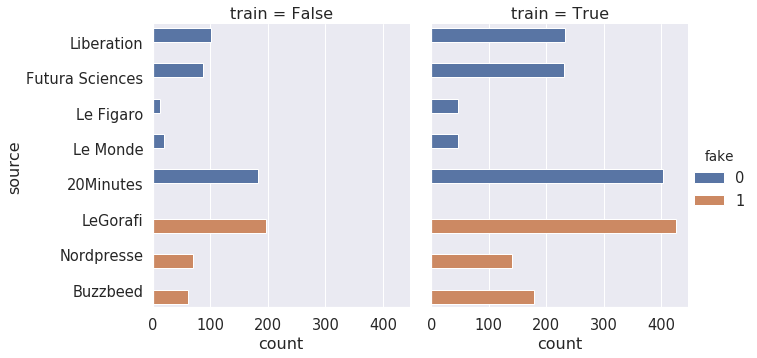

In [92]:
sns.catplot(y="source", hue="fake", col="train", data=df_news, kind="count",
                height=5, aspect=1);
#plt.title("News sources")

### Explore themes

In [93]:
df_news["theme"].nunique()

60

In [94]:
df_news["theme"].unique()

array(['france', 'sante', 'tech', 'sciences', 'planete', 'debats',
       'sports', 'chroniques', 'article', 'maison', 'actu conseils',
       'fonds', 'indices', 'indices actions', 'politiques',
       'evenements libe', 'culture', 'international', 'pixels', 'm perso',
       'afrique', 'politique', 'economie', 'societe', 'football', 'idees',
       'm le mag', 'sport', 'police justice', 'Société', 'Politique',
       'France', 'Economie', 'Sciences', 'Culture', 'Hi-Tech',
       'Gilets Jaunes', 'Start Up Nation', 'Monde', 'Technologies',
       'Violence', 'Sports', 'Religion', 'Medias', 'People', 'Non classé',
       'Honteux', 'Médecine', 'Justice', 'Sexe', 'Insolite',
       'Uncategorized', "Sentiment d'insécurité", 'Préserver la planète',
       'Justice sociale', 'Économie', 'Vivre ensemble', 'Fait divers',
       'Fenêtre sur le monde', 'Fake news'], dtype=object)

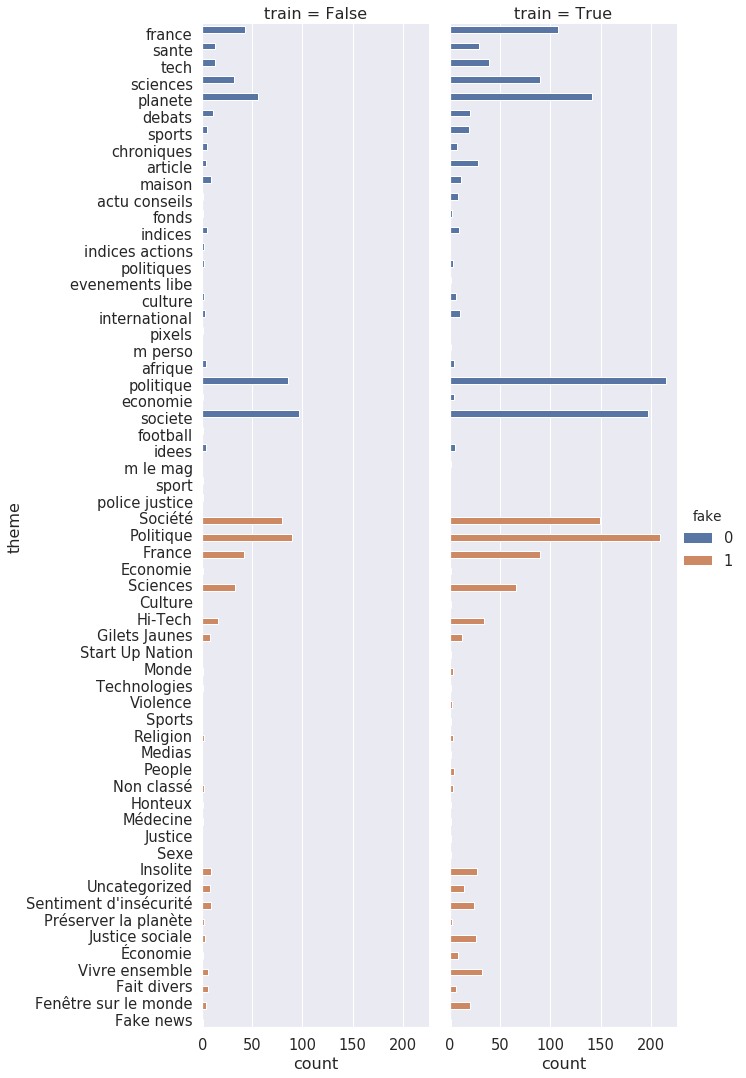

In [95]:
sns.catplot(y="theme", hue="fake", col="train", data=df_news, kind="count",
                height=15, aspect=0.33);

In [0]:
df_news.loc[df_news["theme"] == "France", "theme"] = "france"

In [0]:
df_news.loc[df_news["theme"] == "Médecine", "theme"] = "sante"

In [0]:
df_news.loc[df_news["theme"] == "Technologies", "theme"] = "tech"
df_news.loc[df_news["theme"] == "pixels", "theme"] = "tech"
df_news.loc[df_news["theme"] == "Hi-Tech", "theme"] = "tech"



In [0]:
df_news.loc[df_news["theme"] == "Préserver la planète", "theme"] = "planete"

In [0]:
df_news.loc[df_news["theme"] == "series tv", "theme"] = "television"

In [0]:
df_news.loc[df_news["theme"] == "radio", "theme"] = "medias"

In [0]:
df_news.loc[df_news["theme"] == "Medias", "theme"] = "medias"

In [0]:
df_news.loc[df_news["theme"] == "Sports", "theme"] = "sports"

In [0]:
df_news.loc[df_news["theme"] == "football", "theme"] = "sports"

In [0]:
df_news.loc[df_news["theme"] == "sport", "theme"] = "sports"

In [0]:
df_news.loc[df_news["theme"] == "international", "theme"] = "monde"

In [0]:
df_news.loc[df_news["theme"] == "afrique", "theme"] = "monde"

In [0]:
df_news.loc[df_news["theme"] == "Monde", "theme"] = "monde"

In [0]:
df_news.loc[df_news["theme"] == "Fenêtre sur le monde", "theme"] = "monde"

In [0]:
df_news.loc[df_news["theme"] == "indices", "theme"] = "economie"
df_news.loc[df_news["theme"] == "indices actions", "theme"] = "economie"
df_news.loc[df_news["theme"] == "fonds", "theme"] = "economie"
df_news.loc[df_news["theme"] == "Economie", "theme"] = "economie"
df_news.loc[df_news["theme"] == "Économie", "theme"] = "economie"

In [0]:
df_news.loc[df_news["theme"] == "politiques", "theme"] = "politique"
df_news.loc[df_news["theme"] == "Politique", "theme"] = "politique"

In [0]:
df_news.loc[df_news["theme"] == "Société", "theme"] = "societe"

In [0]:
df_news.loc[df_news["theme"] == "Uncategorized", "theme"] = "non classe"
df_news.loc[df_news["theme"] == "Non classé", "theme"] = "non classe"

In [0]:
df_news.loc[df_news["theme"] == "scenes", "theme"] = "culture"
df_news.loc[df_news["theme"] == "musique", "theme"] = "culture"
df_news.loc[df_news["theme"] == "livre", "theme"] = "culture"

In [0]:
df_news.loc[df_news["theme"] == "Sciences", "theme"] = "sciences"

In [116]:
df_news[df_news["theme"] == "Culture"]["description"].tolist()

['Plus de huit ans déjà que les scientifiques cherchent à résoudre la fameuse opération de la chanson de Grégoire et toujours aucun résultat. Malgré tout, ils refusent d’abandonner le combat.']

In [117]:
df_news[df_news["theme"] == "evenements libe"]["description"].tolist()

["Environnement, social, éducation, consommation... Ils s'engagent au quotidien. Aujourd'hui Etienne Bourgois, président de la Fondation Tara Océan."]

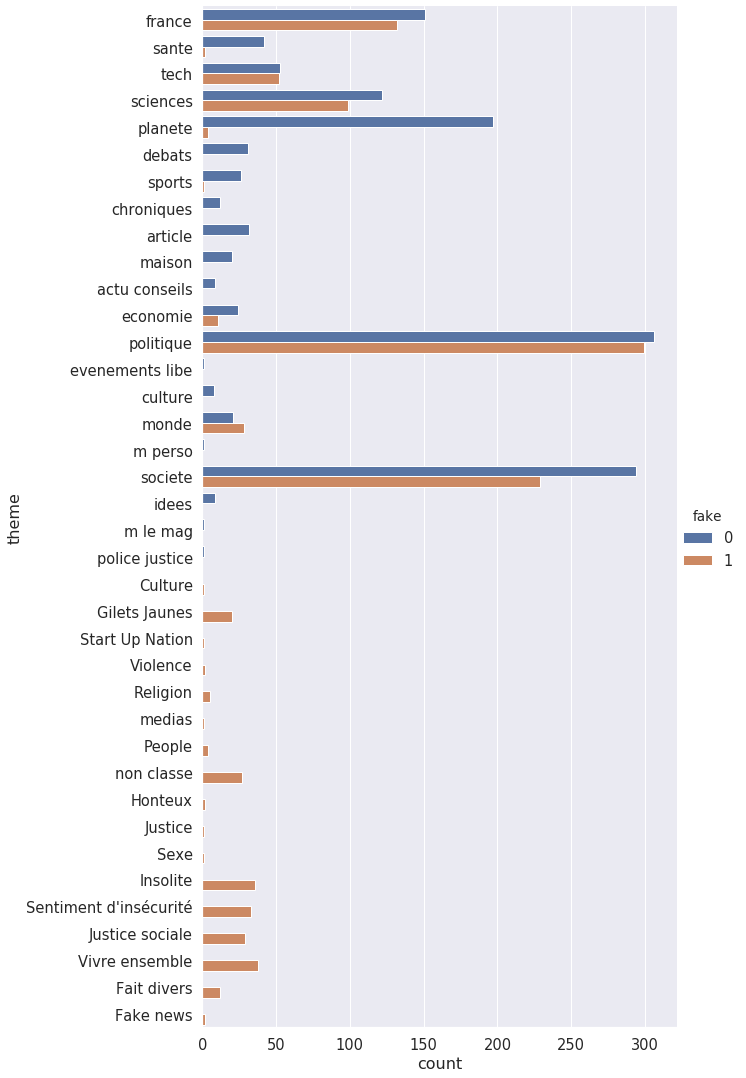

In [118]:
sns.catplot(y="theme", hue="fake",  data=df_news, kind="count",
                height=15, aspect=0.66);

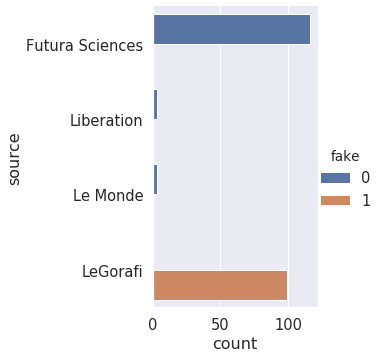

In [119]:
sns.catplot(y="source", hue="fake", data=df_news[df_news["theme"] =="sciences"],
            kind="count");

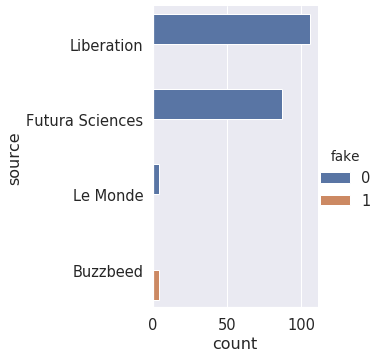

In [120]:
sns.catplot(y="source", hue="fake", data=df_news[df_news["theme"] =="planete"],
            kind="count");

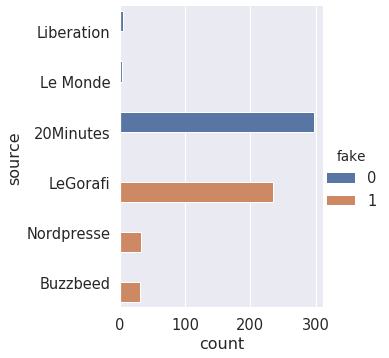

In [121]:
sns.catplot(y="source", hue="fake", 
            data=df_news[df_news["theme"] =="politique"],
            kind="count");

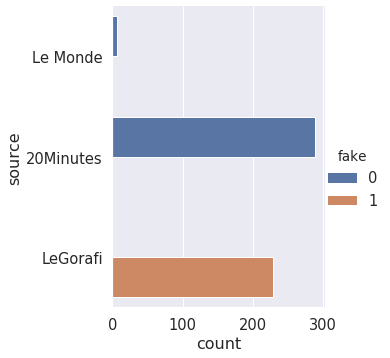

In [122]:
sns.catplot(y="source", hue="fake", 
            data=df_news[df_news["theme"] =="societe"],
            kind="count");

### Number of words per news

In [0]:
def count_words_in_sentence(str_sentence):
  return len(str_sentence.split())

df_news["nb_words"] = df_news["body"].apply(count_words_in_sentence)

(0, 2000)

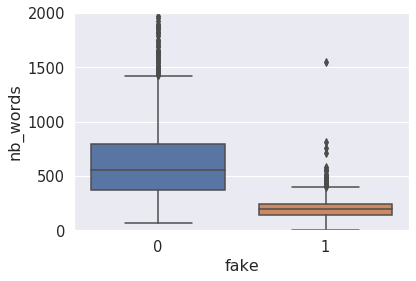

In [124]:
ax = sns.boxplot(x="fake", y="nb_words", data=df_news)

ax.set_ylim([0, 2000])

In [125]:
df_news["nb_words"].max()

89028

In [126]:
# https://nordpresse.be/enfant-noye-mexique-famille-petit-alan-porte-plainte-plagiat/

df_news[df_news["nb_words"] > 80000]

,url,source,author,title,theme,description,date_published,body,fake,text,train,nb_words
2171,https://nordpresse.be/enfant-noye-mexique-fami...,Nordpresse,Vincent Flibustier,Enfant noyé au Mexique: La famille du petit Al...,france,NaN,2019-06-27,C’est l’un des clichés iconiques du drame que ...,1,Enfant noyé au Mexique: La famille du petit Al...,False,89028


In [127]:
df_news[df_news["nb_words"] >80000].index.tolist()

[2171]

In [0]:
df_news.drop(df_news[df_news["nb_words"] >80000].index.tolist(),
             inplace=True)

In [129]:
df_news[df_news["nb_words"] > 80000].shape[0]

0

### Save Data

In [130]:
joblib.dump(df_news, PATH_DF_NEWS_SAVE)

['/content/drive/My Drive/OpenClassRooms/IML_Projet_7/data/df_news.pkl']

### Load Data

In [0]:
df_news = joblib.load(PATH_DF_NEWS_SAVE)

### Format data

Train and Evaluation data needs to be in a Pandas Dataframe of two columns. 

The first column is the text with type str, 
and the second column is the label with type int.

In [132]:
df_news.filter(items=["text", "fake"])

,text,fake
1,Les chefs de service hospitaliers en appellent...,0
2,L'origine des comportements alimentaires ident...,0
3,Microsoft alerte sur de nouvelles techniques d...,0
4,L'Europe se dote d'une infrastructure de téléc...,0
6,Science décalée : la créature la plus rapide s...,0
...,...,...
2529,97% de Libanaises refaites : L’ONU demande au ...,1
2530,Un réfugié syrien humilie et empêche une famil...,1
2531,Mehdi Meklat lance une banane à Christiane Tau...,1
2532,"En visite en Afghanistan, Marine Le Pen refuse...",1


In [0]:
# Train and Evaluation data needs to be in a Pandas Dataframe of two columns. 
train_df = df_news.filter(items=["text", "fake"])[df_news["train"] == True]
eval_df = df_news.filter(items=["text", "fake"])[df_news["train"] == False]

# CamemBERT




### Train model learning_rate : 4e-5

#### First Epochs

In [0]:
# path current
path_current = os.getcwd()
path_folder_model_curr = path_current + '/outputs'

In [136]:
# loop to train without override disk usage
list_acc_train = []
list_acc_test = []
for num_serie in range(0, 10):
  print("Run #", num_serie)
  # Create a ClassificationModel
  # You can set class weights by using the optional weight argument
  model = ClassificationModel('camembert', 'camembert-base', use_cuda=True) 
  # Train the model
  model.train_model(train_df, 
                    args={'fp16': False, 
                          'overwrite_output_dir': True,
                          'num_train_epochs': MAX_NB_EPOCHS})

  # Evaluate the model
  result, model_outputs, wrong_predictions = model.eval_model(eval_df)
  print(result)
  
  # eval train
  y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
  acc_train = accuracy_score(train_df["fake"], y_train_pred)
  print("acc_train: ", acc_train)
  list_acc_train.append(acc_train)
  # eval test
  y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
  acc_test = accuracy_score(eval_df["fake"], y_test_pred)
  print("acc_test: ", acc_test)
  list_acc_test.append(acc_test)

  if (acc_test >= np.max(list_acc_test)):
    # Save model
    save_model_folder(path_folder_model_curr, PATH_FOLDER_MODEL_SAVED)
    result_best = result

print("list_acc_train: ", list_acc_train)  
print("list_acc_test: ", list_acc_test)    
print("best result: ", result_best)
print("best acc_test: ", np.max(list_acc_train))
print("best acc_test: ", np.max(list_acc_test))

Run # 0


/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:160: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn("use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.")


Converting to features started.


Running loss: 0.635830

Running loss: 0.828821

Running loss: 0.007000

Running loss: 0.012653

Running loss: 0.000599

Running loss: 0.000293

Running loss: 0.000173

Running loss: 0.000253

Running loss: 0.000180

Running loss: 0.000426

Running loss: 0.000105

Running loss: 0.000104

Running loss: 0.000162

Running loss: 0.000249

Running loss: 0.000078

Running loss: 0.000135

Running loss: 0.000081

Running loss: 0.000083

Running loss: 0.000177

Running loss: 0.000170

Running loss: 0.000235

Running loss: 0.000116

Running loss: 0.000162

Running loss: 0.000192

Running loss: 0.000172

Running loss: 0.000131

Running loss: 0.000126

Running loss: 0.000162

Running loss: 0.000108

Running loss: 0.000214

Running loss: 0.000196

Running loss: 0.000095

Running loss: 0.000193
Training of camembert model complete. Saved to outputs/.
Converting to features started.



{'mcc': 0.8612781439814885, 'tp': 301, 'tn': 378, 'fp': 25, 'fn': 25, 'eval_loss': 0.5617627023678758}
Converting to features started.



acc_train:  0.9994128009395185
Converting to features started.



acc_test:  0.9314128943758574
Run # 1
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.656770

Running loss: 0.403375

Running loss: 0.776917

Running loss: 0.134343

Running loss: 0.001029

Running loss: 0.000307

Running loss: 0.000247

Running loss: 0.000175

Running loss: 0.000268

Running loss: 0.000084

Running loss: 0.000086

Running loss: 0.000172

Running loss: 0.000082

Running loss: 0.000179

Running loss: 0.000208

Running loss: 0.000149

Running loss: 0.000251

Running loss: 0.000099

Running loss: 0.000133

Running loss: 0.000253

Running loss: 0.000177

Running loss: 0.000188

Running loss: 0.000128

Running loss: 0.000099

Running loss: 0.015711

Running loss: 0.000135

Running loss: 1.217242

Running loss: 0.000028

Running loss: 0.000168

Running loss: 0.000217

Running loss: 0.000075

Running loss: 0.000141

Running loss: 0.000195
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8618139162220557, 'tp': 305, 'tn': 374, 'fp': 29, 'fn': 21, 'eval_loss': 0.5582119149520345}
Converting to features started.



acc_train:  0.9994128009395185
Converting to features started.



acc_test:  0.9314128943758574
Run # 2
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.930723

Running loss: 0.010351

Running loss: 1.940397

Running loss: 0.002198

Running loss: 0.000494

Running loss: 0.000867

Running loss: 0.076218

Running loss: 0.000178

Running loss: 0.000207

Running loss: 0.000468

Running loss: 0.000079

Running loss: 0.000098

Running loss: 0.000133

Running loss: 0.000183

Running loss: 0.000303

Running loss: 0.000116

Running loss: 0.000150

Running loss: 0.000085

Running loss: 0.000106

Running loss: 0.000078

Running loss: 0.000121

Running loss: 0.000081

Running loss: 0.000082

Running loss: 0.000131

Running loss: 0.000131

Running loss: 0.000096

Running loss: 0.000126

Running loss: 1.347415

Running loss: 0.000087

Running loss: 0.000073

Running loss: 0.000138

Running loss: 0.000139

Running loss: 0.000188
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8344275534671138, 'tp': 314, 'tn': 353, 'fp': 50, 'fn': 12, 'eval_loss': 0.7525166726630667}
Converting to features started.



acc_train:  0.9994128009395185
Converting to features started.



acc_test:  0.9149519890260631
Run # 3
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.632937

Running loss: 1.044701

Running loss: 0.004721

Running loss: 0.001137

Running loss: 0.000463

Running loss: 0.264483

Running loss: 0.000058

Running loss: 0.000040

Running loss: 0.000030

Running loss: 0.000021

Running loss: 0.000020

Running loss: 0.000015

Running loss: 0.000013

Running loss: 0.000010

Running loss: 0.000012

Running loss: 0.000009

Running loss: 0.000007

Running loss: 0.000007

Running loss: 0.000006

Running loss: 0.000012

Running loss: 0.000016

Running loss: 0.000010

Running loss: 0.000008

Running loss: 0.000005

Running loss: 0.000005

Running loss: 0.000005

Running loss: 0.000004

Running loss: 0.000005

Running loss: 0.000004

Running loss: 0.000004

Running loss: 0.000003

Running loss: 0.000004

Running loss: 0.000004
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8456414915889275, 'tp': 304, 'tn': 369, 'fp': 34, 'fn': 22, 'eval_loss': 0.6696410197764635}
Converting to features started.



acc_train:  1.0
Converting to features started.



acc_test:  0.9231824417009602
Run # 4
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.770664

Running loss: 0.270974

Running loss: 0.007759

Running loss: 0.007066

Running loss: 0.137084

Running loss: 0.000128

Running loss: 0.000178

Running loss: 0.000171

Running loss: 0.000526

Running loss: 0.000151

Running loss: 0.000126

Running loss: 0.000120

Running loss: 0.000093

Running loss: 0.000099

Running loss: 0.000138

Running loss: 0.718813

Running loss: 0.000176

Running loss: 0.000108

Running loss: 0.000106

Running loss: 0.000162

Running loss: 0.000246

Running loss: 0.000148

Running loss: 1.161884

Running loss: 0.000060

Running loss: 0.000036

Running loss: 0.000020

Running loss: 0.000025

Running loss: 0.000040

Running loss: 0.000026

Running loss: 0.000017

Running loss: 0.000016

Running loss: 0.000018

Running loss: 0.000014
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.815933250677529, 'tp': 301, 'tn': 361, 'fp': 42, 'fn': 25, 'eval_loss': 0.9513047327004049}
Converting to features started.



acc_train:  1.0
Converting to features started.



acc_test:  0.9080932784636488
Run # 5
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.644253

Running loss: 2.177464

Running loss: 0.402344

Running loss: 0.001256

Running loss: 0.000738

Running loss: 0.000259

Running loss: 0.000191

Running loss: 0.000098

Running loss: 0.000269

Running loss: 0.000162

Running loss: 0.000096

Running loss: 0.000227

Running loss: 0.000174

Running loss: 0.000121

Running loss: 0.000428

Running loss: 0.000186

Running loss: 0.000120

Running loss: 0.004950

Running loss: 0.000115

Running loss: 0.000129

Running loss: 0.000072

Running loss: 0.000100

Running loss: 0.000119

Running loss: 0.000096

Running loss: 0.000105

Running loss: 0.000083

Running loss: 0.000203

Running loss: 0.000178

Running loss: 0.000102

Running loss: 0.000095

Running loss: 0.000082

Running loss: 0.000152

Running loss: 0.000155
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8266853597982313, 'tp': 302, 'tn': 364, 'fp': 39, 'fn': 24, 'eval_loss': 0.6810721669589048}
Converting to features started.



acc_train:  0.9994128009395185
Converting to features started.



acc_test:  0.9135802469135802
Run # 6
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.620197

Running loss: 1.374701

Running loss: 0.005430

Running loss: 0.002428

Running loss: 0.000270

Running loss: 0.000440

Running loss: 0.000284

Running loss: 0.000235

Running loss: 0.000290

Running loss: 0.000240

Running loss: 0.000115

Running loss: 0.000116

Running loss: 0.000110

Running loss: 0.000139

Running loss: 0.000206

Running loss: 0.000130

Running loss: 0.000069

Running loss: 0.000120

Running loss: 0.000094

Running loss: 0.000089

Running loss: 0.000159

Running loss: 0.000126

Running loss: 0.000171

Running loss: 0.000161

Running loss: 0.000116

Running loss: 0.000258

Running loss: 0.000199

Running loss: 0.000216

Running loss: 0.000177

Running loss: 0.000086

Running loss: 0.000129

Running loss: 0.000127

Running loss: 0.000056
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8233918740259295, 'tp': 312, 'tn': 351, 'fp': 52, 'fn': 14, 'eval_loss': 0.790618406365747}
Converting to features started.



acc_train:  0.9994128009395185
Converting to features started.



acc_test:  0.9094650205761317
Run # 7
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.664033

Running loss: 0.114388

Running loss: 0.685369

Running loss: 0.003151

Running loss: 0.000676

Running loss: 0.000345

Running loss: 0.000200

Running loss: 0.000161

Running loss: 0.000161

Running loss: 0.000129

Running loss: 0.000168

Running loss: 0.000159

Running loss: 0.000084

Running loss: 0.000226

Running loss: 0.000082

Running loss: 0.000134

Running loss: 0.000077

Running loss: 0.000198

Running loss: 0.000084

Running loss: 0.000202

Running loss: 0.000192

Running loss: 0.000184

Running loss: 0.000054

Running loss: 0.000122

Running loss: 0.000167

Running loss: 0.000158

Running loss: 0.000116

Running loss: 0.000100

Running loss: 0.000107

Running loss: 0.000154

Running loss: 0.000093

Running loss: 0.000165

Running loss: 0.000194
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.85053443888302, 'tp': 311, 'tn': 363, 'fp': 40, 'fn': 15, 'eval_loss': 0.6356149204075336}
Converting to features started.



acc_train:  0.9994128009395185
Converting to features started.



acc_test:  0.9245541838134431
Run # 8
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.720581

Running loss: 0.257392

Running loss: 0.057160

Running loss: 0.001271

Running loss: 0.000504

Running loss: 0.000335

Running loss: 0.000125

Running loss: 0.000122

Running loss: 0.000135

Running loss: 0.000260

Running loss: 0.000170

Running loss: 0.000089

Running loss: 0.000183

Running loss: 0.000252

Running loss: 0.000129

Running loss: 0.000187

Running loss: 0.000109

Running loss: 0.000101

Running loss: 0.000171

Running loss: 0.000074

Running loss: 0.000123

Running loss: 0.000553

Running loss: 0.000289

Running loss: 0.000347

Running loss: 0.000116

Running loss: 0.000121

Running loss: 0.000105

Running loss: 0.000187

Running loss: 0.000220

Running loss: 0.000168

Running loss: 0.000116

Running loss: 0.000236

Running loss: 0.000174
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8543320507155882, 'tp': 307, 'tn': 369, 'fp': 34, 'fn': 19, 'eval_loss': 0.6313310501206181}
Converting to features started.



acc_train:  0.9994128009395185
Converting to features started.



acc_test:  0.9272976680384087
Run # 9
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1703


Running loss: 0.665691

Running loss: 0.537093

Running loss: 0.007992

Running loss: 1.071905

Running loss: 0.000851

Running loss: 0.000196

Running loss: 0.000131

Running loss: 0.000215

Running loss: 0.000088

Running loss: 0.000086

Running loss: 0.000065

Running loss: 0.000172

Running loss: 0.000118

Running loss: 0.000129

Running loss: 0.000079

Running loss: 0.000110

Running loss: 0.000131

Running loss: 0.000118

Running loss: 0.000206

Running loss: 0.041784

Running loss: 0.000167

Running loss: 0.000190

Running loss: 0.000219

Running loss: 0.000188

Running loss: 0.000155

Running loss: 0.000200

Running loss: 0.000093

Running loss: 0.000184

Running loss: 0.000108

Running loss: 0.000208

Running loss: 0.000108

Running loss: 0.000138

Running loss: 0.000212
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_729



{'mcc': 0.8500387288200666, 'tp': 295, 'tn': 380, 'fp': 23, 'fn': 31, 'eval_loss': 0.5908874969767488}
Converting to features started.



acc_train:  0.9994128009395185
Converting to features started.



acc_test:  0.9259259259259259
list_acc_train:  [0.9994128009395185, 0.9994128009395185, 0.9994128009395185, 1.0, 1.0, 0.9994128009395185, 0.9994128009395185, 0.9994128009395185, 0.9994128009395185, 0.9994128009395185]
list_acc_test:  [0.9314128943758574, 0.9314128943758574, 0.9149519890260631, 0.9231824417009602, 0.9080932784636488, 0.9135802469135802, 0.9094650205761317, 0.9245541838134431, 0.9272976680384087, 0.9259259259259259]
best result:  {'mcc': 0.8618139162220557, 'tp': 305, 'tn': 374, 'fp': 29, 'fn': 21, 'eval_loss': 0.5582119149520345}
best acc_test:  1.0
best acc_test:  0.9314128943758574


#### Eval Saved Model

In [0]:
# load model
model = ClassificationModel('camembert', PATH_FOLDER_MODEL_SAVED)
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)
# eval train
y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
print("acc score Train : ", accuracy_score(train_df["fake"], y_train_pred))
# eval test
y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
print("acc score Test : ", accuracy_score(eval_df["fake"], y_test_pred))


### Change learning rate

#### Learning rate : 1e-5

In [0]:
PATH_FOLDER_MODEL_SAVED_2 = PATH_FOLDER_MODEL_SAVED + '_2'
PATH_FOLDER_MODEL_SAVED_2

'/content/drive/My Drive/outputs_proj7_2'

In [0]:
# Create a ClassificationModel
# You can set class weights by using the optional weight argument
model = ClassificationModel('camembert', 'camembert-base', use_cuda=True) 

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:159: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn("use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.")


In [0]:
# Train the model
model.train_model(train_df, 
                  args={'learning_rate': 1e-5,
                        'fp16': False, 
                        'overwrite_output_dir': True,
                        'num_train_epochs': MAX_NB_EPOCHS})

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)

# Save model
save_model_folder(path_folder_model_curr, PATH_FOLDER_MODEL_SAVED_2)

Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.867216

Running loss: 0.445972

Running loss: 0.125293

Running loss: 0.004465

Running loss: 0.000836

Running loss: 2.998290

Running loss: 0.000350

Running loss: 0.000323

Running loss: 0.000318

Running loss: 0.000174
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.7962458594065657, 'tp': 247, 'tn': 238, 'fp': 27, 'fn': 28, 'eval_loss': 0.5539147782632533}


In [0]:
train_df["text"]

1       Les chefs de service hospitaliers en appellent...
2       L'origine des comportements alimentaires ident...
4       L'Europe se dote d'une infrastructure de téléc...
5       À Bry-sur-Marne, Louis Daguerre, le père de la...
6       Science décalée : la créature la plus rapide s...
                              ...                        
1793    97% de Libanaises refaites : L’ONU demande au ...
1794    Un réfugié syrien humilie et empêche une famil...
1795    Mehdi Meklat lance une banane à Christiane Tau...
1796    En visite en Afghanistan, Marine Le Pen refuse...
1797    Insolite : il supprime 50 000 tweets en une nu...
Name: text, Length: 1258, dtype: object

In [0]:
# eval train
y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
# eval test
y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())

Converting to features started.



Converting to features started.


In [0]:
accuracy_score(train_df["fake"], y_train_pred)

0.9904610492845787

In [0]:
accuracy_score(eval_df["fake"], y_test_pred)

0.8981481481481481

In [0]:
# Train the model
model.train_model(train_df, 
                  args={'learning_rate': 1e-5,
                        'fp16': False, 
                        'overwrite_output_dir': True,
                        'num_train_epochs': MAX_NB_EPOCHS})

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)
# eval train
y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
print("acc score Train : ", accuracy_score(train_df["fake"], y_train_pred))
# eval test
y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
print("acc score Test : ", accuracy_score(eval_df["fake"], y_test_pred))
# Save model
save_model_folder(path_folder_model_curr, PATH_FOLDER_MODEL_SAVED_2)

Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.000275

Running loss: 0.000056

Running loss: 0.000059

Running loss: 0.000030

Running loss: 0.000021

Running loss: 0.000016

Running loss: 0.000016

Running loss: 0.000020

Running loss: 0.000015

Running loss: 0.000012
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.8336372946800589, 'tp': 257, 'tn': 238, 'fp': 27, 'fn': 18, 'eval_loss': 0.7186138906023082}
Converting to features started.



acc score Train :  1.0
Converting to features started.



acc score Test :  0.9166666666666666


In [0]:
# Train the model
model.train_model(train_df, 
                  args={'learning_rate': 1e-5,
                        'fp16': False, 
                        'overwrite_output_dir': True,
                        'num_train_epochs': MAX_NB_EPOCHS})

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)
# eval train
y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
print("acc score Train : ", accuracy_score(train_df["fake"], y_train_pred))
# eval test
y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
print("acc score Test : ", accuracy_score(eval_df["fake"], y_test_pred))
# Save model
save_model_folder(path_folder_model_curr, PATH_FOLDER_MODEL_SAVED_2)

Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.000106

Running loss: 0.000023

Running loss: 0.000010

Running loss: 0.000014

Running loss: 0.000007

Running loss: 0.000006

Running loss: 0.000007

Running loss: 0.000007

Running loss: 0.000005

Running loss: 0.000006
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.8338421657097536, 'tp': 248, 'tn': 247, 'fp': 18, 'fn': 27, 'eval_loss': 0.7941739107756054}
Converting to features started.



acc score Train :  1.0
Converting to features started.



acc score Test :  0.9166666666666666


#### Learning rate 5e-6

In [0]:
PATH_FOLDER_MODEL_SAVED_3 = PATH_FOLDER_MODEL_SAVED + '_3'
PATH_FOLDER_MODEL_SAVED_3

'/content/drive/My Drive/outputs_proj7_3'

In [0]:
# path current
path_current = os.getcwd()
path_folder_model_curr = path_current + '/outputs'

In [0]:
# Train and Evaluation data needs to be in a Pandas Dataframe of two columns. 
train_df = df_news.filter(items=["text", "fake"])[df_news["train"] == True]
eval_df = df_news.filter(items=["text", "fake"])[df_news["train"] == False]

In [0]:
# Create a ClassificationModel
# You can set class weights by using the optional weight argument
model = ClassificationModel('camembert', 'camembert-base', use_cuda=True)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:159: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn("use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.")


In [0]:
# loop to train without override disk usage
for num_serie in range(0,3):  
  print("Epochs : {} -> {}".format(num_serie*MAX_NB_EPOCHS, 
                                   (num_serie + 1)*MAX_NB_EPOCHS))
  # Train the model
  model.train_model(train_df, 
                  args={'learning_rate': 5e-6,
                        'fp16': False, 
                        'overwrite_output_dir': True,
                        'num_train_epochs': MAX_NB_EPOCHS})
  # Evaluate the model
  result, model_outputs, wrong_predictions = model.eval_model(eval_df)
  print(result)
  # eval train
  y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
  print("acc score Train : ", accuracy_score(train_df["fake"], y_train_pred))
  # eval test
  y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
  print("acc score Test : ", accuracy_score(eval_df["fake"], y_test_pred))
  # Save model
  save_model_folder(path_folder_model_curr, PATH_FOLDER_MODEL_SAVED_3)

Epochs : 0 -> 10
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.726125

Running loss: 0.403860

Running loss: 1.624202

Running loss: 0.010520

Running loss: 0.435758

Running loss: 0.024872

Running loss: 0.071624

Running loss: 0.006189

Running loss: 0.013561

Running loss: 0.131269
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.771241930226689, 'tp': 238, 'tn': 240, 'fp': 25, 'fn': 37, 'eval_loss': 0.402804860187804}
Converting to features started.



acc score Train :  0.9531001589825119
Converting to features started.



acc score Test :  0.8851851851851852
Epochs : 10 -> 20
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.000474

Running loss: 0.000497

Running loss: 0.000142

Running loss: 0.000312

Running loss: 0.000170

Running loss: 0.000153

Running loss: 0.000204

Running loss: 0.000221

Running loss: 0.000160

Running loss: 0.000139
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.807482826809392, 'tp': 247, 'tn': 241, 'fp': 24, 'fn': 28, 'eval_loss': 0.6414881148101652}
Converting to features started.



acc score Train :  0.9952305246422893
Converting to features started.



acc score Test :  0.9037037037037037
Epochs : 20 -> 30
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.000312

Running loss: 0.000165

Running loss: 0.000113

Running loss: 0.000135

Running loss: 0.000109

Running loss: 0.000091

Running loss: 0.000045

Running loss: 0.000046

Running loss: 0.000036

Running loss: 0.000049
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.8464627850028342, 'tp': 245, 'tn': 253, 'fp': 12, 'fn': 30, 'eval_loss': 0.7061375158236307}
Converting to features started.



acc score Train :  1.0
Converting to features started.



acc score Test :  0.9222222222222223


In [0]:
# loop to train without override disk usage
for num_serie in range(0,3):  
  print("Epochs : {} -> {}".format(num_serie*MAX_NB_EPOCHS, 
                                   (num_serie + 1)*MAX_NB_EPOCHS))
  # Train the model
  model.train_model(train_df, 
                  args={'learning_rate': 5e-6,
                        'fp16': False, 
                        'overwrite_output_dir': True,
                        'num_train_epochs': MAX_NB_EPOCHS})
  # Evaluate the model
  result, model_outputs, wrong_predictions = model.eval_model(eval_df)
  print(result)
  # eval train
  y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
  print("acc score Train : ", accuracy_score(train_df["fake"], y_train_pred))
  # eval test
  y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
  print("acc score Test : ", accuracy_score(eval_df["fake"], y_test_pred))
  # Save model
  save_model_folder(path_folder_model_curr, PATH_FOLDER_MODEL_SAVED_3)

Epochs : 0 -> 10
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.000033

Running loss: 0.000035

Running loss: 0.000013

Running loss: 0.000011

Running loss: 0.000010

Running loss: 0.000008

Running loss: 0.000006

Running loss: 0.000006

Running loss: 0.000007

Running loss: 0.000009
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.8446771434279804, 'tp': 258, 'tn': 240, 'fp': 25, 'fn': 17, 'eval_loss': 0.7240705250159782}
Converting to features started.



acc score Train :  1.0
Converting to features started.



acc score Test :  0.9222222222222223
Epochs : 10 -> 20
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.000004

Running loss: 0.000006

Running loss: 0.000006

Running loss: 0.000005

Running loss: 0.000003

Running loss: 0.000004

Running loss: 0.000003

Running loss: 0.000003

Running loss: 0.000004

Running loss: 0.000003
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.8308510229786665, 'tp': 245, 'tn': 249, 'fp': 16, 'fn': 30, 'eval_loss': 0.8164340293801883}
Converting to features started.



acc score Train :  1.0
Converting to features started.



acc score Test :  0.9148148148148149
Epochs : 20 -> 30
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.000004

Running loss: 0.000006

Running loss: 0.000006

Running loss: 0.000003

Running loss: 0.000004

Running loss: 0.000004

Running loss: 0.000004

Running loss: 0.000005

Running loss: 0.000002

Running loss: 0.000004
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.8446636688899876, 'tp': 251, 'tn': 247, 'fp': 18, 'fn': 24, 'eval_loss': 0.6205289382487535}
Converting to features started.



acc score Train :  1.0
Converting to features started.



acc score Test :  0.9222222222222223


#### Learning rate 1e-4

In [0]:
learning_rate = 1e-4

In [0]:
PATH_FOLDER_MODEL_SAVED_4 = PATH_FOLDER_MODEL_SAVED + '_4'
PATH_FOLDER_MODEL_SAVED_4

'/content/drive/My Drive/outputs_proj7_4'

In [0]:
# path current
path_current = os.getcwd()
path_folder_model_curr = path_current + '/outputs'

In [0]:
# Train and Evaluation data needs to be in a Pandas Dataframe of two columns. 
train_df = df_news.filter(items=["text", "fake"])[df_news["train"] == True]
eval_df = df_news.filter(items=["text", "fake"])[df_news["train"] == False]

In [0]:
# Create a ClassificationModel
# You can set class weights by using the optional weight argument
model = ClassificationModel('camembert', 'camembert-base', use_cuda=True)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:159: UserWarning: use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.
  warnings.warn("use_multiprocessing automatically disabled as CamemBERT fails when using multiprocessing for feature conversion.")


In [0]:
# loop to train without override disk usage
list_acc_train = []
list_acc_test = []
for num_serie in range(0,1):  
  print("Epochs : {} -> {}".format(num_serie*MAX_NB_EPOCHS, 
                                   (num_serie + 1)*MAX_NB_EPOCHS))
  # Train the model
  model.train_model(train_df, 
                  args={'learning_rate': learning_rate,
                        'fp16': False, 
                        'overwrite_output_dir': True,
                        'num_train_epochs': MAX_NB_EPOCHS})
  # Evaluate the model
  result, model_outputs, wrong_predictions = model.eval_model(eval_df)
  print(result)
  # eval train
  y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
  acc_train = accuracy_score(train_df["fake"], y_train_pred)
  list_acc_train.append(acc_train)
  print("acc score Train : ", acc_train)
  # eval test
  y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
  acc_test = accuracy_score(eval_df["fake"], y_test_pred)
  list_acc_test.append(acc_test)
  print("acc score Test : ", acc_test)
  # Save model
  save_model_folder(path_folder_model_curr, PATH_FOLDER_MODEL_SAVED_4)

print("acc_train : ", list_acc_train)
print("acc_test : ", list_acc_test)

Epochs : 0 -> 10
Converting to features started.


Running loss: 0.446631

Running loss: 0.695528

Running loss: 0.735159

Running loss: 0.932052

Running loss: 0.170576

Running loss: 0.015739

Running loss: 0.025410

Running loss: 0.009211

Running loss: 0.006438

Running loss: 0.006145
Training of camembert model complete. Saved to outputs/.
Converting to features started.



{'mcc': 0.6557227593991318, 'tp': 234, 'tn': 213, 'fp': 52, 'fn': 41, 'eval_loss': 0.8162523267023704}
Converting to features started.



acc score Train :  0.9833068362480127
Converting to features started.



acc score Test :  0.8277777777777777
acc_train :  [0.9833068362480127]
acc_test :  [0.8277777777777777]


In [0]:
# loop to train without override disk usage
for num_serie in range(0,2):  
  print("Epochs : {} -> {}".format(num_serie*MAX_NB_EPOCHS, 
                                   (num_serie + 1)*MAX_NB_EPOCHS))
  # Train the model
  model.train_model(train_df, 
                  args={'learning_rate': learning_rate,
                        'fp16': False, 
                        'overwrite_output_dir': True,
                        'num_train_epochs': MAX_NB_EPOCHS})
  # Evaluate the model
  result, model_outputs, wrong_predictions = model.eval_model(eval_df)
  print(result)
  # eval train
  y_train_pred, raw_outputs = model.predict(train_df["text"].tolist())
  acc_train = accuracy_score(train_df["fake"], y_train_pred)
  list_acc_train.append(acc_train)
  print("acc score Train : ", acc_train)
  # eval test
  y_test_pred, raw_outputs = model.predict(eval_df["text"].tolist())
  acc_test = accuracy_score(eval_df["fake"], y_test_pred)
  list_acc_test.append(acc_test)
  print("acc score Test : ", acc_test)
  # Save model
  save_model_folder(path_folder_model_curr, PATH_FOLDER_MODEL_SAVED_4)

print("acc_train : ", list_acc_train)
print("acc_test : ", list_acc_test)

Epochs : 0 -> 10
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.003695

Running loss: 2.165467

Running loss: 0.029749

Running loss: 1.135359

Running loss: 0.255367

Running loss: 0.913658

Running loss: 0.291558

Running loss: 0.333446

Running loss: 0.116279

Running loss: 0.112019
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.6646364238132936, 'tp': 271, 'tn': 168, 'fp': 97, 'fn': 4, 'eval_loss': 0.4362836668596548}
Converting to features started.



acc score Train :  0.8608903020667726
Converting to features started.



acc score Test :  0.812962962962963
Epochs : 10 -> 20
Features loaded from cache at cache_dir/cached_train_camembert_128_2_1258


Running loss: 0.082238

Running loss: 0.046756

Running loss: 0.013025

Running loss: 0.018648

Running loss: 0.010866

Running loss: 0.007476

Running loss: 0.021249

Running loss: 0.123954

Running loss: 0.112022

Running loss: 0.309237
Training of camembert model complete. Saved to outputs/.
Features loaded from cache at cache_dir/cached_dev_camembert_128_2_540



{'mcc': 0.6307225461024834, 'tp': 272, 'tn': 155, 'fp': 110, 'fn': 3, 'eval_loss': 0.4595602779265712}
Converting to features started.



acc score Train :  0.8267090620031796
Converting to features started.



acc score Test :  0.7907407407407407
acc_train :  [0.9833068362480127, 0.8608903020667726, 0.8267090620031796]
acc_test :  [0.8277777777777777, 0.812962962962963, 0.7907407407407407]


#### A ENLEVER